In [2]:
import sys, os
sys.path.append(os.path.abspath("../src"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from pathlib import Path

from models import prepare_lstm_data, build_lstm
from eval_utils import all_metrics

c:\Users\bhupe\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("data/processed/RELIANCE.NS_close.csv", index_col=0, parse_dates=True)
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df = df.dropna()

In [4]:
X_train, y_train, X_test, y_test, scaler = prepare_lstm_data(df['close'].values, lookback=60)


In [6]:
model = build_lstm((X_train.shape[1], 1))
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[es], verbose=2)


Epoch 1/30
59/59 - 2s - 32ms/step - loss: 0.0196 - val_loss: 0.0013
Epoch 2/30
59/59 - 1s - 13ms/step - loss: 0.0016 - val_loss: 4.3260e-04
Epoch 3/30
59/59 - 1s - 15ms/step - loss: 0.0015 - val_loss: 4.3192e-04
Epoch 4/30
59/59 - 1s - 13ms/step - loss: 0.0014 - val_loss: 8.5849e-04
Epoch 5/30
59/59 - 1s - 14ms/step - loss: 0.0013 - val_loss: 4.8638e-04
Epoch 6/30
59/59 - 1s - 13ms/step - loss: 0.0012 - val_loss: 3.7371e-04
Epoch 7/30
59/59 - 1s - 13ms/step - loss: 0.0012 - val_loss: 4.8666e-04
Epoch 8/30
59/59 - 1s - 13ms/step - loss: 0.0011 - val_loss: 4.6975e-04
Epoch 9/30
59/59 - 1s - 13ms/step - loss: 9.8958e-04 - val_loss: 4.7052e-04
Epoch 10/30
59/59 - 1s - 12ms/step - loss: 9.1753e-04 - val_loss: 5.6047e-04
Epoch 11/30
59/59 - 1s - 14ms/step - loss: 9.6588e-04 - val_loss: 6.4760e-04


In [7]:
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [10]:
pred_len = len(pred)
pred_index = df.index[-pred_len:]
pred_series = pd.Series(pred.flatten(), index=pred_index)
true_series = df['close'].iloc[-pred_len:]


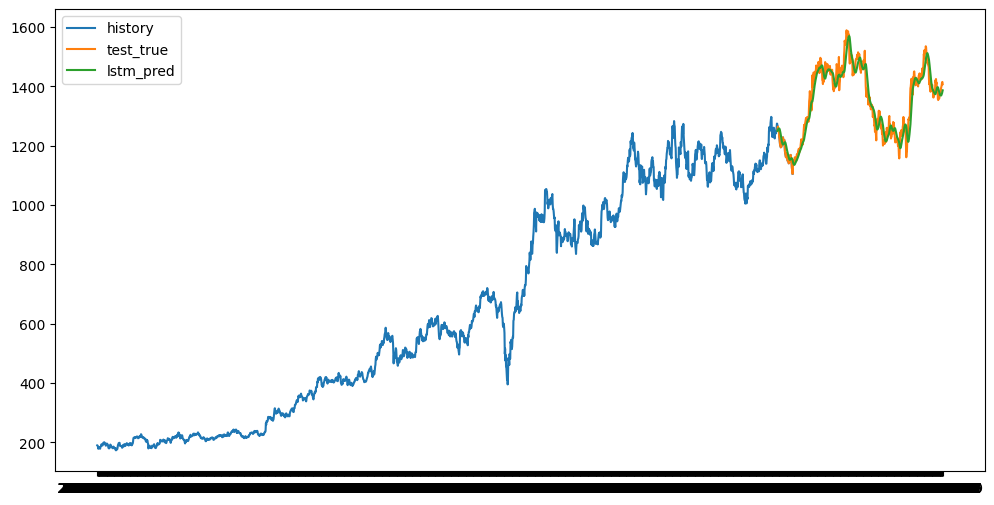

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df.index[:pred_start], df['close'][:pred_start], label='history')
plt.plot(true_series.index, true_series, label='test_true')
plt.plot(pred_series.index, pred_series, label='lstm_pred')
plt.legend(); plt.show()


In [12]:
metrics_lstm = all_metrics(true_series.values, pred_series.values)
print("LSTM metrics:", metrics_lstm)


LSTM metrics: {'MAE': 26.663356707363054, 'RMSE': 34.202737240066995, 'MAPE': 1.9737676353447526}


In [13]:
Path("models").mkdir(exist_ok=True)
model.save("models/lstm_model.h5")